# Reference Solution for Assignment "Trustworthy FL"

## 1. Preparation

### 1.1 Libraries

In [1]:
# Modules.
import numpy as np 
import pandas as pd 
import networkx as nx 

# Submodules
import matplotlib.pyplot as plt 
from numpy import linalg as LA

# Methods
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

### 1.2 Helper functions

In [2]:
# The function generates a scatter plot of nodes (=FMI stations) using 
# latitude and longitude as coordinates. 
def plotFMI(G_FMI):    
    # Get the coordinates of the stations.
    coords = np.array([G_FMI.nodes[node]['coord'] for node in G_FMI.nodes])
    
    # Draw nodes
    for node in G_FMI.nodes:
        plt.scatter(coords[node,1], coords[node,0], color='black', s=4, zorder=5)  # zorder ensures nodes are on top of edges
        plt.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    # Draw edges
    for edge in G_FMI.edges:
        plt.plot([coords[edge[0],1],coords[edge[1],1]], [coords[edge[0],0],coords[edge[1],0]], linestyle='-', color='gray', alpha=0.5)

    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('FMI stations')
    plt.show()
    
    
# The function connects each FMI station with 
# the nearest neighbours. 
def add_edges(graph, numneighbors=4):
    # Get the coordinates of the stations.
    coords = np.array([G_FMI.nodes[node]['coord'] for node in G_FMI.nodes])
    
    A = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)
    nrnodes = len(graph.nodes)
    for iter_i in range(nrnodes): 
        for iter_ii in range(nrnodes): 
            if iter_i != iter_ii : 
                if A[iter_i,iter_ii]> 0 :
                    graph.add_edge(iter_i, iter_ii)
    return graph

# The function below extracts a feature and label from each row 
# of dataframe df. Each row is expected to hold a FMI weather 
# measurement with cols "Latitude", "Longitude", "temp", "Timestamp". 
# Returns numpy arrays X, y.
def ExtractFeatureMatrixLabelVector(data):
    nrfeatures = 7 
    nrdatapoints = len(data)
    
    # We build the feature matrix X (each of its rows hold the features of a data point) 
    # and the label vector y (whose entries hold the labels of data points).
    X = np.zeros((nrdatapoints, nrfeatures))
    y = np.zeros((nrdatapoints, 1))

    # Iterate over all rows in dataframe and create corresponding feature vector and label. 
    for ind in range(nrdatapoints):
        # Latitude of FMI station, normalized by 100. 
        lat = float(data['Latitude'].iloc[ind])/100
        # Longitude of FMI station, normalized by 100.
        lon = float(data['Longitude'].iloc[ind])/100
        # Temperature value of the data point.
        tmp = data['temp'].iloc[ind]
        # Read the date and time of the temperature measurement. 
        date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')
        # Extract year, month, day, hour, and minute. Normalize these values 
        # to ensure that the features are in range [0,1].
        year = float(date_object.year)/2025
        month = float(date_object.month)/13
        day = float(date_object.day)/32
        hour = float(date_object.hour)/25
        minute = float(date_object.minute)/61
        
        # Store the data point's features and a label.
        X[ind,:] = [lat, lon, year, month, day, hour, minute]
        y[ind,:] = tmp

    return X, y

### 1.3 Some hyperparameters

In [3]:
# Define the random seed to be used everywhere.
seed = 4740

## 2 Data

### 2.1 Dataset

In [4]:
# Import the weather measurements.
data = pd.read_csv('Assignment_MLBasicsData.csv')

# We consider each temperature measurement (=a row in dataframe) as a 
# separate data point.

# Define the numbers of data points, the unique stations, and features. 
num_stations = len(data.name.unique())
num_datapoints = len(data)

### 2.2 Features and labels

In [5]:
# Extract features and labels from the FMI data.
X, y = ExtractFeatureMatrixLabelVector(data)

print(f"The created feature matrix contains {np.shape(X)[0]} entries of {np.shape(X)[1]} features each.")
print(f"The created label vector contains {np.shape(y)[0]} measurements.")

The created feature matrix contains 19768 entries of 7 features each.
The created label vector contains 19768 measurements.


### 2.3 Empirical graph

The empirical graph is connected: True


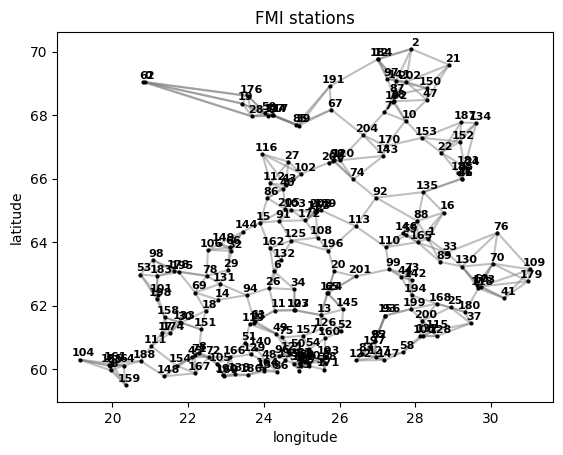

In [6]:
# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, num_stations))

for i, station in enumerate(data.name.unique()):
    # Extract data of a certain station
    station_data = data[data.name==station]
    
    # Extract features and labels
    X_local, y_local = ExtractFeatureMatrixLabelVector(station_data)
    
    # Split the dataset into training and validation set. 
    X_train, X_val, y_train, y_val = train_test_split(X_local, y_local, test_size=0.2, random_state=seed)

    localsamplesize = len(y)
    G_FMI.nodes[i]['sample_size'] = localsamplesize # The number of measurements of the i-th weather station
    G_FMI.nodes[i]['name'] = station # The name of the i-th weather station
    G_FMI.nodes[i]['coord'] = (station_data.Latitude.unique()[0], station_data.Longitude.unique()[0]) # The coordinates of the i-th weather station
    G_FMI.nodes[i]['X_train'] = X_train # The training feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_train'] = y_train  # The training label vector for local dataset at node i
    G_FMI.nodes[i]['X_val'] = X_val # The training feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_val'] = y_val  # The training label vector for local dataset at node i
    G_FMI.nodes[i]['weights'] = np.zeros((7, 1)) # The weight vector for local dataset at node i
    G_FMI.nodes[i]['epsilon'] = np.zeros_like(y_local) # The perturbation for local dataset at node i

# Add edges between each station and its nearest neighbors.
# NOTE: the node degree might be different for different nodes.
numneighbors = 4
G_FMI = add_edges(G_FMI, numneighbors=numneighbors)
print("The empirical graph is connected:", nx.is_connected(G_FMI))

# Visualize the empirical graph.
plotFMI(G_FMI)

## 3. Model

### 3.1 FedGD without perturbations

In [7]:
def FedGD(graph_FMI, alpha=0.5, l_rate=0.1, max_iter=1000):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()
    
    # Initialize all weight vectors with zeros 
    for node in graph.nodes:
        graph.nodes[node]['weights'] = np.zeros((7, 1))
    
    for i in range(max_iter):
        # Iterate over all nodes.
        for current_node in graph.nodes:

            # Extract the training data from the current node.
            X_train = graph.nodes[current_node]['X_train']
            y_train = graph.nodes[current_node]['y_train']
            w_current = graph.nodes[current_node]['weights']
            training_size = len(y_train)

            # Compute the first term of the Equation 5.8.
            term_1 = (2/training_size) * X_train.T.dot(y_train - X_train.dot(w_current))
            # Compute the second term of the Equation 5.8
            # by receiving neighbors' weight vectors.
            term_2 = 0
            neighbors = list(graph.neighbors(current_node))
            for neighbor in neighbors:
                w_neighbor = graph.nodes[neighbor]['weights']
                term_2 += w_neighbor - w_current
            term_2 *= 2*alpha
            # Equation 5.8
            w_updated = w_current + l_rate * (term_1 + term_2)

            # Update the current weight vector but do not overwrite the 
            # "weights" attribute as we need to do all updates synchronously, i.e., 
            # using the previous local params. 

            graph.nodes[current_node]['newweights'] = w_updated

        # After computing the new localparmas for each node, we now update 
        # the node attribute 'weights' for all nodes. 
        for node in graph.nodes: 
            graph.nodes[node]['weights'] = graph.nodes[node]['newweights']
            
    return graph

In [8]:
# Perform Federated Gradient Descent with default parameters.
G_FMI_FedGD = FedGD(G_FMI)

# Extract the updated local models' parameters. 
weights_original_data = np.array([G_FMI_FedGD.nodes[node]['weights'] for node in G_FMI_FedGD.nodes])

# Sanity check. 
print(f'The shape of the original weights is {weights_original_data.shape}')

The shape of the original weights is (207, 7, 1)


### 3.2 Student task #1 - The effect of perturbations on the local model parameters

In [9]:
def FedGD_perturbed(graph_FMI, alpha=0.5, l_rate=0.1, max_iter=1000, variance=1, mean=0, seed=4740):
    # Define the random seed.
    np.random.seed(seed)
        
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()
    
    # Progress log.
    print(f'Train on the perturbed data with mean = {mean} and variance = {variance}...')

    # Initialize all weight vectors with zeros 
    for node in graph.nodes:
        graph.nodes[node]['weights'] = np.zeros((7, 1))

    # Add perturbations.
    # Epsilon ~ N(mean, variance)
    for node in graph.nodes:
        trainsize = len(graph.nodes[node]['y_train'])
        graph.nodes[node]['epsilon'] = mean + np.random.randn(trainsize, 1) * variance

    for i in range(max_iter):
        # Iterate over all nodes.
        for current_node in graph.nodes:

            # Extract the training data from the current node.
            X_train = graph.nodes[current_node]['X_train']
            y_train = graph.nodes[current_node]['y_train'] + graph.nodes[current_node]['epsilon']
            w_current = graph.nodes[current_node]['weights']
            training_size = len(y_train)

            # Compute the first term of the Equation 5.8.
            term_1 = (2/training_size) * X_train.T.dot(y_train - X_train.dot(w_current))
            # Compute the second term of the Equation 5.8
            # by receiving neighbors' weight vectors.
            term_2 = 0
            neighbors = list(graph.neighbors(current_node))
            for neighbor in neighbors:
                w_neighbor = graph.nodes[neighbor]['weights']
                term_2 += w_neighbor - w_current
            term_2 *= 2*alpha
            # Equation 5.8
            w_updated = w_current + l_rate * (term_1 + term_2)

            # Update the current weight vector but do not overwrite the 
            # "weights" attribute as we need to do all updates synchronously, i.e., 
            # using the previous local params 

            graph.nodes[current_node]['newweights'] = w_updated

        # after computing the new localparmas for each node, we now update 
        # the node attribute 'weights' for all nodes 
        for node in graph.nodes: 
            graph.nodes[node]['weights'] = graph.nodes[node]['newweights']
            
    return graph

Train on the perturbed data with mean = 0 and variance = 0...
Train on the perturbed data with mean = 0 and variance = 5...
Train on the perturbed data with mean = 0 and variance = 10...
Train on the perturbed data with mean = 0 and variance = 15...
Train on the perturbed data with mean = 0 and variance = 20...
Train on the perturbed data with mean = 0 and variance = 25...
Train on the perturbed data with mean = 0 and variance = 30...
Train on the perturbed data with mean = 0 and variance = 35...
Train on the perturbed data with mean = 0 and variance = 40...
Train on the perturbed data with mean = 0 and variance = 45...
Train on the perturbed data with mean = 0 and variance = 50...
Train on the perturbed data with mean = 0 and variance = 55...


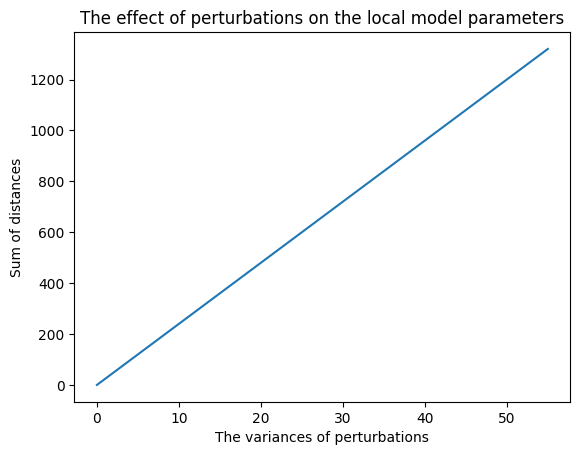

In [10]:
# Define the variances to test.
variances = np.arange(0, 56, 5)

# Define the storage for the sums of distances
# between the weight vectors.
sum_distances = np.zeros(len(variances))

# Try different variances.
for n_variance, variance in enumerate(variances):
    # Update the local models' parameters with perturbed labels.
    # 
    G_FMI_FedGD_perturbed = FedGD_perturbed(G_FMI, variance=variance)
    weights_perturbed_data = np.array([G_FMI_FedGD_perturbed.nodes[node]['weights'] 
                                       for node in G_FMI_FedGD_perturbed.nodes])
    sum_distances[n_variance] = np.sum(LA.norm((weights_original_data - weights_perturbed_data), axis=1))

# Plot the results.
plt.plot(variances, sum_distances)
plt.xlabel("The variances of perturbations")
plt.ylabel("Sum of distances")
plt.title("The effect of perturbations on the local model parameters")
plt.show()

Train on the perturbed data with mean = 0 and variance = 1...
Train on the perturbed data with mean = 5 and variance = 1...
Train on the perturbed data with mean = 10 and variance = 1...
Train on the perturbed data with mean = 15 and variance = 1...
Train on the perturbed data with mean = 20 and variance = 1...
Train on the perturbed data with mean = 25 and variance = 1...
Train on the perturbed data with mean = 30 and variance = 1...
Train on the perturbed data with mean = 35 and variance = 1...
Train on the perturbed data with mean = 40 and variance = 1...
Train on the perturbed data with mean = 45 and variance = 1...
Train on the perturbed data with mean = 50 and variance = 1...
Train on the perturbed data with mean = 55 and variance = 1...


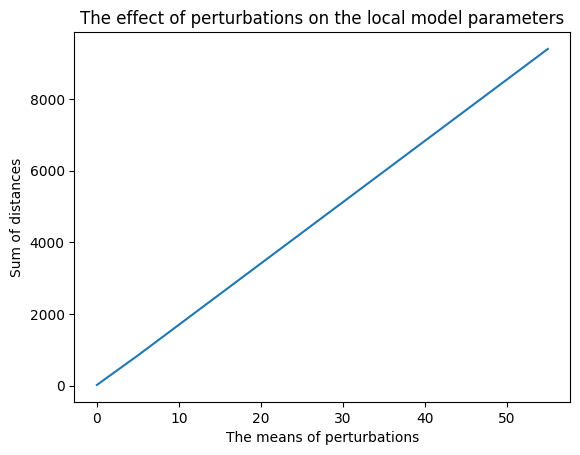

In [11]:
# Define the means to test.
means = np.arange(0, 56, 5)

# Define the storage for the sums of distances
# between the weight vectors.
sum_distances = np.zeros(len(means))

# Try different means.
for n_mean, mean in enumerate(means):
    # Update the local models' parameters with perturbed labels.
    G_FMI_FedGD_perturbed = FedGD_perturbed(G_FMI, mean=mean)
    weights_perturbed_data = np.array([G_FMI_FedGD_perturbed.nodes[node]['weights'] 
                                       for node in G_FMI_FedGD_perturbed.nodes])
    sum_distances[n_mean] = np.sum(LA.norm((weights_original_data - weights_perturbed_data), axis=1))

# Plot the results.
plt.plot(means, sum_distances)
plt.xlabel("The means of perturbations")
plt.ylabel("Sum of distances")
plt.title("The effect of perturbations on the local model parameters")
plt.show()

In [19]:
def calculate_sum_distances(graph_FMI, mean, variance, alpha=0.5, l_rate=0.1, max_iter=1000):

    # Original (unperturbed) model parameters (assuming these have been previously computed)
    # If not, you would need to run the unperturbed FedGD first to obtain the original weights.
    original_weights = np.array([G_FMI.nodes[node]['weights'] for node in G_FMI.nodes]).squeeze()

    # Run FedGD with perturbation
    G_FMI_perturbed = FedGD_perturbed(graph_FMI, alpha=alpha, l_rate=l_rate, max_iter=max_iter, variance=variance, mean=mean)
    
    # Collect perturbed model parameters
    perturbed_weights = np.array([G_FMI_perturbed.nodes[node]['weights'] for node in G_FMI_perturbed.nodes]).squeeze()
    
    print(f"Original weights shape: {original_weights.shape}")
    print(f"Perturbed weights shape: {perturbed_weights.shape}")
    # Compute Euclidean distance between original and perturbed weights for each node and sum them
    sum_distances = np.sum([np.sqrt(np.sum((original_weights[i] - perturbed_weights[i]) ** 2)) for i in range(len(original_weights))])
    
    # sum_distances = np.sum(np.sqrt((original_weights - perturbed_weights) ** 2))
    return sum_distances



# Calculate sum of distances for perturbations ~ N(1, 10)
sum_distances_case_1 = calculate_sum_distances(G_FMI, mean=1, variance=10)

# Calculate sum of distances for perturbations ~ N(10, 1)
sum_distances_case_2 = calculate_sum_distances(G_FMI, mean=10, variance=1)

print(f"Sum of distances for perturbations ~ N(1, 10): {sum_distances_case_1}")
print(f"Sum of distances for perturbations ~ N(10, 1): {sum_distances_case_2}")

Train on the perturbed data with mean = 1 and variance = 10...
Original weights shape: (207, 7)
Perturbed weights shape: (207, 7)
Train on the perturbed data with mean = 10 and variance = 1...
Original weights shape: (207, 7)
Perturbed weights shape: (207, 7)
Sum of distances for perturbations ~ N(1, 10): 4554.260546820076
Sum of distances for perturbations ~ N(10, 1): 3642.3096079211155
